# Nama: Hendrikus Yohanes Wunga
# NIM: 225314039

## Penjelasan Kode

Kode ini memuat beberapa library penting yang digunakan dalam analisis data, visualisasi, dan pembelajaran mesin:

1. **Import Library**:
    ```python
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import tensorflow as tf
    import warnings
    ```

    - `matplotlib.pyplot`: Digunakan untuk membuat plot dan visualisasi data.
    - `numpy`: Digunakan untuk operasi numerik, seperti array dan fungsi matematika.
    - `os`: Digunakan untuk berinteraksi dengan sistem operasi, seperti mengelola file dan direktori.
    - `tensorflow`: Digunakan untuk membuat dan melatih model pembelajaran mesin dan jaringan saraf.
    - `warnings`: Digunakan untuk mengelola peringatan (warnings) dalam kode Python.

2. **Mengabaikan Peringatan**:
    ```python
    warnings.filterwarnings("ignore")
    ```

    - Kode ini digunakan untuk mengabaikan semua peringatan yang mungkin muncul selama eksekusi kode, sehingga output lebih bersih dan hanya menampilkan informasi yang penting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

## Preprocessing Data

Mengunduh Data
kita akan menggunakan dataset yang berisi beberapa ribu gambar kucing dan anjing. Unduh dan ekstrak file zip yang berisi gambar-gambar tersebut, lalu buatlah tf.data.Dataset untuk pelatihan dan validasi dengan menggunakan utilitas tf.keras.utils.image_dataset_from_directory


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Menampilkan sembilan gambar dan label pertama dari set pelatihan

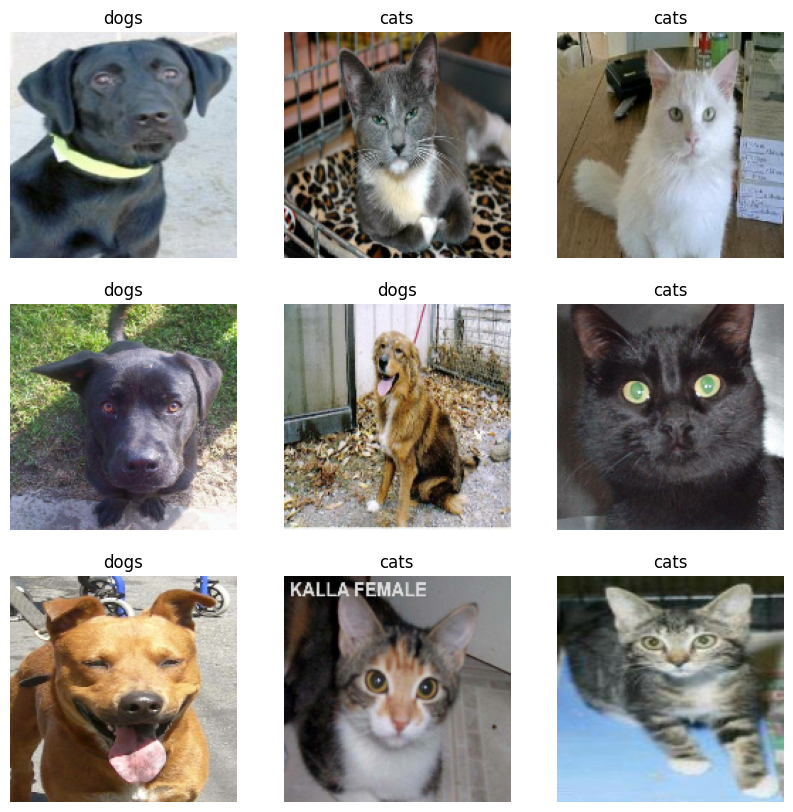

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Untuk membuat set uji, kita pertama-tama menentukan berapa banyak batch data yang tersedia di set validasi menggunakan `tf.data.experimental.cardinality(validation_dataset)`. Lalu, kita ambil 20% dari set validasi untuk digunakan sebagai set uji menggunakan `validation_dataset.take(val_batches // 5)`, dan sisanya dipertahankan untuk set validasi dengan menggunakan `validation_dataset.skip(val_batches // 5)`.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Setelah itu, kita mencetak jumlah batch di set validasi dan set uji

In [5]:
print('Jumlah batch validasi: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Jumlah batch pengujian: %d' % tf.data.experimental.cardinality(test_dataset))

Jumlah batch validasi: 26
Jumlah batch pengujian: 6


# Mengonfigurasi dataset untuk kinerja
Kode ini bertujuan untuk meningkatkan kinerja pelatihan model dengan menggunakan prefetching. Prefetching adalah teknik yang memungkinkan pengambilan data untuk dilakukan secara asinkron, sehingga sementara CPU atau GPU sedang melakukan komputasi, data dapat dipersiapkan secara paralel untuk batch berikutnya.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Menggunakan Augmentasi Data
`data_augmentation` adalah sebuah sequential model dalam TensorFlow Keras yang digunakan untuk melakukan augmentasi data pada gambar. Augmentasi data adalah teknik yang digunakan dalam pelatihan model machine learning untuk meningkatkan keragaman data dan mengurangi overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

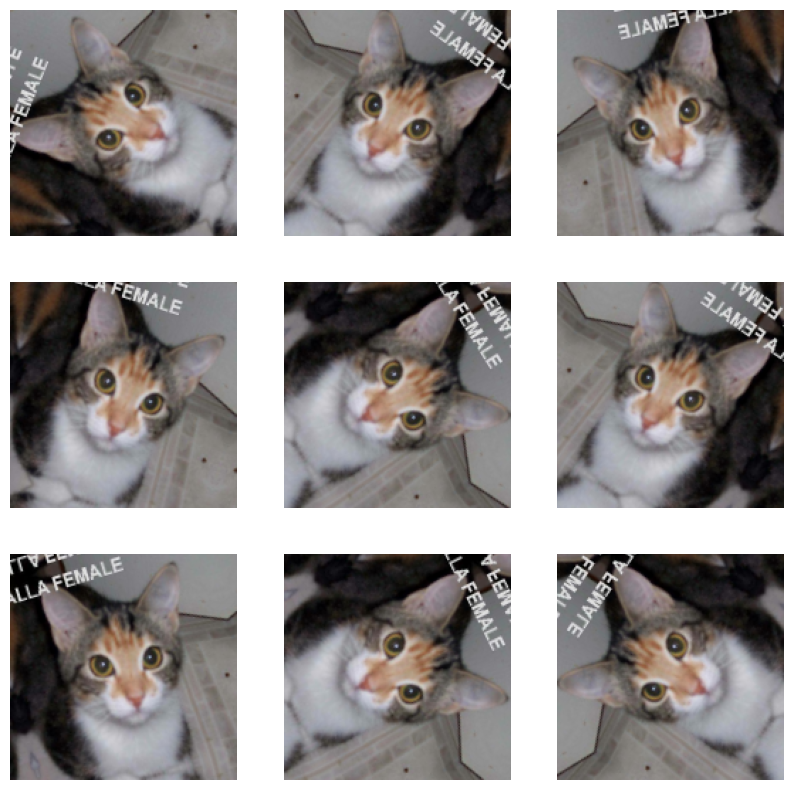

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Hyperparameter

In [11]:
base_learning_rate = 0.0001
fine_tune_at = 100
initial_epochs = 10
fine_tune_epochs = 60
total_epochs = initial_epochs + fine_tune_epochs

### Arsitektur Model

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
len(model.trainable_variables)

2

### Model Compile Algoritma Optimizer Adam

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [22]:
%%time
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.5305 - loss: 0.7764
CPU times: total: 26 s
Wall time: 20 s


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.78
initial accuracy: 0.53


### Model Fit Algoritma Optimizer Adam

In [24]:
%%time
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, verbose=0)

CPU times: total: 16min 54s
Wall time: 25min 47s


### Evaluasi learning dan testing untuk grafik performance dan loss function Algoritma Optimizer Adam

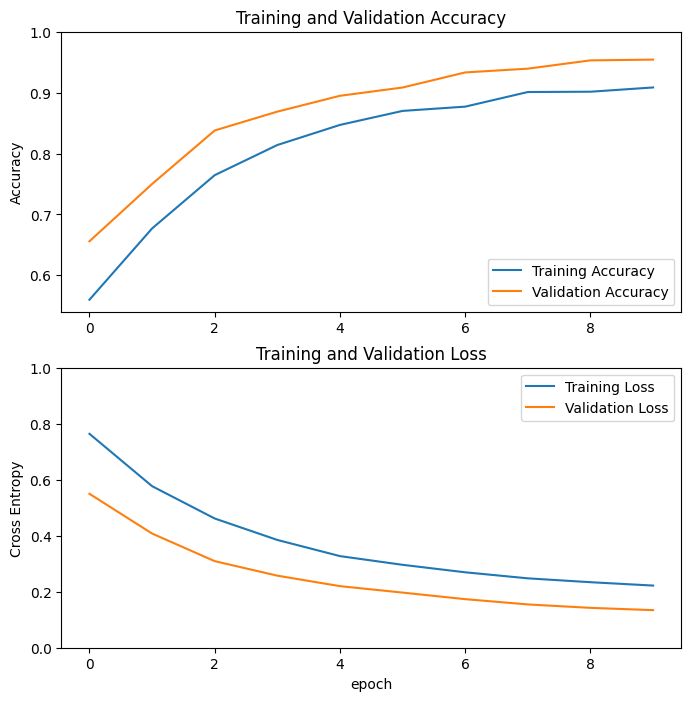

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# print final training and validation accuracy
loss, accuracy = model.evaluate(train_dataset)
print("Training accuracy: {:.2f}".format(accuracy))

loss, accuracy = model.evaluate(validation_dataset)
print("Validation accuracy: {:.2f}".format(accuracy))

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 427ms/step - accuracy: 0.9570 - loss: 0.1258
Training accuracy: 0.96
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.9532 - loss: 0.1291
Validation accuracy: 0.96


In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Model Compile Algoritma Optimizers RMSprop

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [30]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [31]:
len(model.trainable_variables)

56

### Model Fit Algoritma Opimizer RMSprop

In [32]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset, verbose=1)

Epoch 10/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8162 - loss: 0.4538 - val_accuracy: 0.9728 - val_loss: 0.0859
Epoch 11/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 949ms/step - accuracy: 0.8994 - loss: 0.2959 - val_accuracy: 0.9814 - val_loss: 0.0673
Epoch 12/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9152 - loss: 0.2287 - val_accuracy: 0.9802 - val_loss: 0.0670
Epoch 13/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9265 - loss: 0.1860 - val_accuracy: 0.9839 - val_loss: 0.0604
Epoch 14/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.9325 - loss: 0.1802 - val_accuracy: 0.9851 - val_loss: 0.0560
Epoch 15/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9264 - loss: 0.1643 - val_accuracy: 0.9851 - val_loss: 0.0485
Epoch 16/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9542 - loss: 0.1347 - val_accuracy: 0.9827 - val_loss: 0.0436
Epoch 17/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9337 - loss: 0.1536 - val_accuracy: 0.980

### Evaluasi learning dan testing untuk grafik performance dan loss function Algoritma Optimizer RMSprop

In [33]:
# Initialize the variables as lists
acc = []
val_acc = []
loss = []
val_loss = []

# Add the history data
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

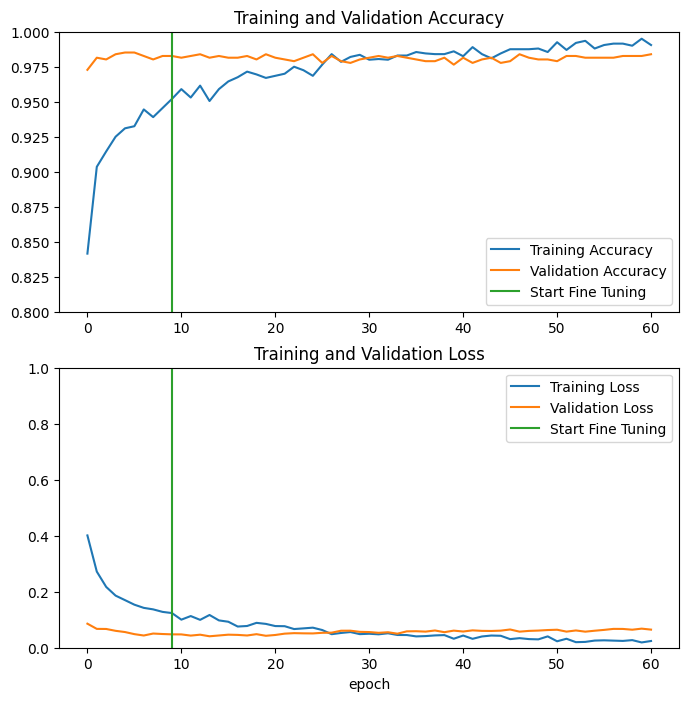

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
# print the training and validation accuracies of the fine-tuned model
loss, accuracy = model.evaluate(train_dataset)
print("Training accuracy: {:.2f}".format(accuracy))

loss, accuracy = model.evaluate(validation_dataset)
print("Validation accuracy: {:.2f}".format(accuracy))

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step - accuracy: 0.9989 - loss: 0.0040
Training accuracy: 1.00
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.9828 - loss: 0.0819
Validation accuracy: 0.98


In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.9818 - loss: 0.0368
Test accuracy : 0.984375


Predictions:
 [1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1]
Labels:
 [1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1]


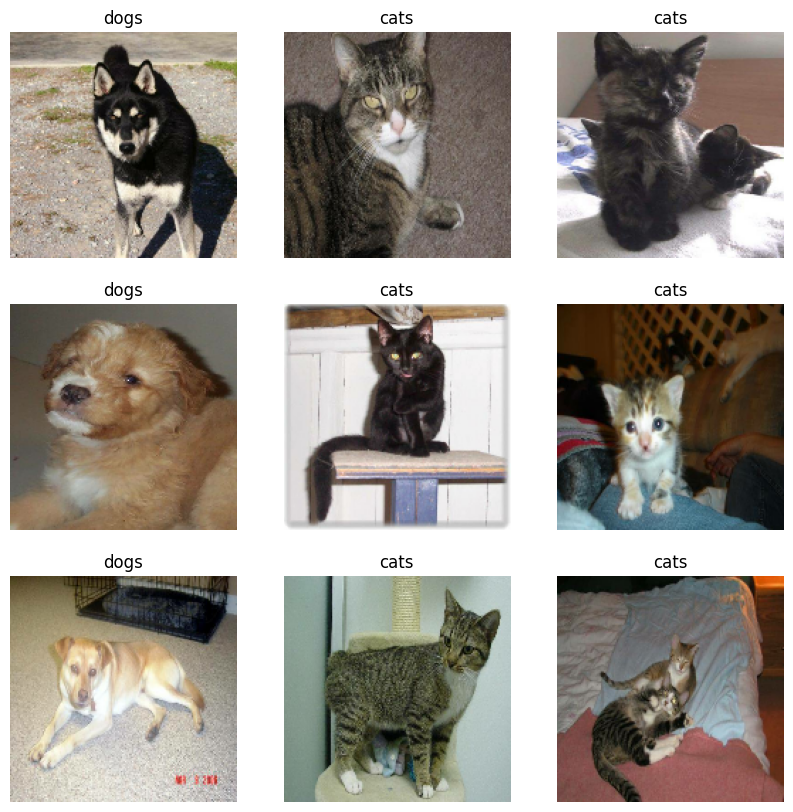

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Model Convolutional Neural Network (CNN) menggunakan MobileNetV2 untuk Transfer Learning

## Arsitektur Model CNN

1. **Preprocessing Data**:
   - Data gambar diambil dari dataset 'cats_and_dogs_filtered' yang telah diunduh dan diekstrak.
   - Dilakukan augmentasi data menggunakan `tf.keras.Sequential` yang terdiri dari `RandomFlip` dan `RandomRotation` untuk memperkaya variasi data pelatihan.

2. **Base Model (MobileNetV2)**:
   - Base model MobileNetV2 diinisialisasi dengan `input_shape` yang sesuai dengan ukuran gambar (160x160) dan dimensi warna RGB (3 channel).
   - `include_top=False` digunakan untuk menghilangkan layer fully connected yang biasanya digunakan untuk klasifikasi 1000 kelas pada ImageNet.
   - Bobot dari MobileNetV2 yang telah dilatih di ImageNet digunakan untuk memanfaatkan transfer learning.

3. **Feature Extraction**:
   - Data masukan gambar melewati base model untuk ekstraksi fitur.
   - Hasilnya kemudian diproses menggunakan `GlobalAveragePooling2D` untuk menghasilkan representasi rata-rata dari fitur-fitur spatialis.

4. **Output Layer**:
   - Layer dense dengan 1 neuron digunakan sebagai output untuk klasifikasi biner (kucing atau anjing).
   - Activation function yang digunakan adalah linear karena output dari model belum diubah menjadi probabilitas dengan sigmoid.

5. **Model Final**:
   - Keseluruhan model dibangun menggunakan `tf.keras.Model` dengan input dari data augmentasi dan output dari layer prediksi.

## Proses Pelatihan dan Evaluasi

1. **Pelatihan Awal**:
   - Model di-compile dengan optimizer Adam, loss BinaryCrossentropy (dari logits), dan metrik BinaryAccuracy dengan threshold 0.5.
   - Dilakukan evaluasi awal pada dataset validasi untuk mendapatkan baseline loss dan accuracy sebelum pelatihan.

2. **Pelatihan**:
   - Pelatihan dilakukan dengan jumlah epoch awal yang ditentukan (`initial_epochs=10`) menggunakan `model.fit`.
   - Dilakukan monitoring terhadap training dan validation loss serta accuracy untuk setiap epoch.

3. **Fine-tuning**:
   - Bagian akhir dari MobileNetV2 dibuka untuk dilatih ulang (fine-tuning) dengan learning rate yang lebih kecil.
   - Model kembali di-compile dengan optimizer RMSprop yang learning ratenya diubah menjadi 10 kali lebih kecil dari sebelumnya.
   - Dilakukan pelatihan tambahan (`fine_tune_epochs`) dengan total epoch yang sudah ditentukan.

4. **Evaluasi Akhir**:
   - Setelah pelatihan selesai, model dievaluasi pada dataset training, validation, dan testing untuk mengukur performa akhirnya.
   - Hasil evaluasi ditampilkan dalam bentuk akurasi untuk masing-masing dataset.

## Grafik Performa dan Loss Function

- **Training and Validation Accuracy**: Grafik menunjukkan perkembangan akurasi training dan validation selama proses pelatihan. Tujuannya adalah untuk melihat apakah model mampu mempelajari pola dari data training tanpa terlalu overfitting terhadap data validasi.
  
- **Training and Validation Loss**: Grafik ini menggambarkan perubahan nilai loss (Binary Crossentropy) pada setiap epoch untuk training dan validation. Idealnya, kita ingin melihat penurunan loss secara konsisten baik pada training maupun validation.

## Evaluasi pada Data Testing

- **Testing Accuracy**: Setelah pelatihan selesai, model dievaluasi pada dataset testing yang telah dipisahkan dari dataset validasi. Hal ini memberikan gambaran akurasi yang bisa diharapkan ketika model diterapkan pada data baru yang belum pernah dilihat.

## Kesimpulan

Model CNN yang dikembangkan menggabungkan transfer learning menggunakan MobileNetV2 dengan fine-tuning pada bagian akhirnya. Dengan demikian, model dapat memanfaatkan representasi fitur yang sudah baik dari MobileNetV2 untuk melakukan klasifikasi biner antara gambar kucing dan anjing dengan hasil evaluasi yang baik pada data testing. Grafik performa dan loss function memberikan gambaran yang jelas tentang proses pelatihan dan peningkatan model dari epoch ke epoch.
